# **Dataset 3**

### **Import Packages**

In [1]:
import multiprocessing
import subprocess
import pandas as pd
from sklearn.model_selection import train_test_split

from Data_Generation.data_synthesizer import ds_generate_data
from Data_Generation.synthetic_data_vault import sdv_generate_data
from Data_Evaluation.utility import run_utility_eval
from Data_Evaluation.resemblance import pairwise_correlation_diff, jsd, wd
from Data_Evaluation.privacy import dcr, nndr, mia
from sklearn.preprocessing import LabelEncoder

### **Exploratory Data Analysis**

In [2]:
# Load the dataset as dataframe
data_path = "Original_Data/Dataset_3.csv"
original_data = pd.read_csv(data_path)
original_data.head()

,Gender,Age,POLAR4 Quintile,POLAR3 Quintile,Adult HE 2001 Quintile,Adult HE 2011 Quintile,TUNDRA MSOA Quintile,TUNDRA LSOA Quintile,Gaps GCSE Quintile,Gaps GCSE Ethnicity Quintile,Uni Connect target ward,attending from home?,distance to university (km),Count of Module Area Logins,Total Hours in Module Area,% of Average Hours in Module Area,# of presence,# of Absence,Percent Attended,"label (fail=1, pass=0)",Unnamed: 20,Unnamed: 21
0,0.0,38.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,0.0,1.0,13.333806,19.0,7.41,0.620767,3.0,9.0,25.000000,1.0,NaN,NaN
1,0.0,22.0,4.0,2.0,1.0,3.0,4.0,4.0,4.0,5.0,0.0,1.0,15.844126,1.0,0.03,0.002513,0.0,12.0,0.000000,1.0,NaN,NaN
2,0.0,21.0,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,0.0,1.0,17.706573,25.0,6.14,0.514374,5.0,7.0,41.666667,1.0,NaN,NaN
3,0.0,25.0,5.0,4.0,3.0,4.0,3.0,3.0,5.0,5.0,0.0,0.0,17.327498,3.0,0.16,0.013404,0.0,12.0,0.000000,1.0,NaN,NaN
4,0.0,20.0,5.0,4.0,3.0,4.0,3.0,3.0,4.0,4.0,0.0,1.0,0.000000,25.0,4.03,0.337610,11.0,1.0,91.666667,1.0,NaN,NaN


In [3]:
# Get general information about the dataset
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             80 non-null     float64
 1   Age                                80 non-null     float64
 2   POLAR4 Quintile                    80 non-null     float64
 3   POLAR3 Quintile                    80 non-null     float64
 4   Adult HE 2001 Quintile             80 non-null     float64
 5   Adult HE 2011 Quintile             80 non-null     float64
 6   TUNDRA MSOA Quintile               80 non-null     float64
 7   TUNDRA LSOA Quintile               80 non-null     float64
 8   Gaps GCSE Quintile                 80 non-null     float64
 9   Gaps GCSE Ethnicity Quintile       80 non-null     float64
 10  Uni Connect target ward            80 non-null     float64
 11  attending from home?               80 non-null     float64
 

In [4]:
# Check for missing values
original_data.isnull().sum()

Gender                                7
Age                                   7
POLAR4 Quintile                       7
POLAR3 Quintile                       7
Adult HE 2001 Quintile                7
Adult HE 2011 Quintile                7
TUNDRA MSOA Quintile                  7
TUNDRA LSOA Quintile                  7
Gaps GCSE Quintile                    7
Gaps GCSE Ethnicity Quintile          7
Uni Connect target ward               7
attending from home?                  7
distance to university (km)           7
Count of Module Area Logins           7
Total Hours in Module Area            7
% of Average Hours in Module Area     7
# of presence                         7
# of Absence                          9
Percent Attended                      7
label (fail=1, pass=0)                7
Unnamed: 20                          87
Unnamed: 21                          87
dtype: int64

In [5]:
original_data.tail(10)

,Gender,Age,POLAR4 Quintile,POLAR3 Quintile,Adult HE 2001 Quintile,Adult HE 2011 Quintile,TUNDRA MSOA Quintile,TUNDRA LSOA Quintile,Gaps GCSE Quintile,Gaps GCSE Ethnicity Quintile,Uni Connect target ward,attending from home?,distance to university (km),Count of Module Area Logins,Total Hours in Module Area,% of Average Hours in Module Area,# of presence,# of Absence,Percent Attended,"label (fail=1, pass=0)",Unnamed: 20,Unnamed: 21
77,0.0,22.0,3.0,4.0,3.0,4.0,3.0,3.0,5.0,5.0,0.0,1.0,10.235646,32.0,5.68,0.475838,11.0,1.0,91.666667,0.0,NaN,NaN
78,1.0,21.0,5.0,4.0,3.0,4.0,4.0,4.0,4.0,5.0,0.0,1.0,56.938766,35.0,15.59,1.306041,8.0,4.0,66.666667,0.0,NaN,NaN
79,1.0,20.0,5.0,5.0,4.0,4.0,3.0,3.0,5.0,5.0,0.0,0.0,20.031985,23.0,16.30,1.365520,5.0,7.0,41.666667,0.0,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Findings: 
- 2 columns without any values
- last 7 rows without any values
- 2 additional missing values in column '# of Absence'

Thus:
- remove empty rows and columns and fill remaining missing values

In [6]:
# Drop empty columns
original_data.drop(['Unnamed: 20'], axis=1, inplace=True)
original_data.drop(['Unnamed: 21'], axis=1, inplace=True)

# Drop last 7 rows
original_data.drop(original_data.tail(7).index, inplace=True)
original_data.tail(10)

# Fill missing values with the mode of the column
original_data = original_data.fillna(original_data.mode().iloc[0])


In [7]:
# Check again for missing values
original_data.isnull().sum()

Gender                               0
Age                                  0
POLAR4 Quintile                      0
POLAR3 Quintile                      0
Adult HE 2001 Quintile               0
Adult HE 2011 Quintile               0
TUNDRA MSOA Quintile                 0
TUNDRA LSOA Quintile                 0
Gaps GCSE Quintile                   0
Gaps GCSE Ethnicity Quintile         0
Uni Connect target ward              0
attending from home?                 0
distance to university (km)          0
Count of Module Area Logins          0
Total Hours in Module Area           0
% of Average Hours in Module Area    0
# of presence                        0
# of Absence                         0
Percent Attended                     0
label (fail=1, pass=0)               0
dtype: int64

In [8]:
# Check number of unique values in each column
original_data.nunique()

Gender                                2
Age                                  12
POLAR4 Quintile                       5
POLAR3 Quintile                       5
Adult HE 2001 Quintile                5
Adult HE 2011 Quintile                6
TUNDRA MSOA Quintile                  6
TUNDRA LSOA Quintile                  6
Gaps GCSE Quintile                    6
Gaps GCSE Ethnicity Quintile          6
Uni Connect target ward               2
attending from home?                  2
distance to university (km)          46
Count of Module Area Logins          49
Total Hours in Module Area           78
% of Average Hours in Module Area    78
# of presence                        12
# of Absence                         11
Percent Attended                     14
label (fail=1, pass=0)                2
dtype: int64

In [9]:
# Check categorical columns
categorical_cols = original_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(col, original_data[col].unique())

### **Synthetic Data Generation**

In [10]:
# Set the start method of the multiprocessing module to 'fork' to avoid an error
multiprocessing.set_start_method('fork', force=True)

# Number of samples to generate
n = 5000

train_data, test_data = train_test_split(original_data, test_size=0.3, random_state=42)
train_data.to_csv("Original_Data/train_data.csv", index=False)
test_data.to_csv("Original_Data/test_data.csv", index=False)

In [11]:
# Use train_data.csv to fit SDG models and generate synthetic data
data_path = "Original_Data/train_data.csv"
arguments = [data_path, str(n)]

print("Sampling synthpop...")
result = subprocess.run(['Rscript', 'Data_Generation/synthpop.R',   *arguments], capture_output=True, text=True)

print("Sampling DataSynthesizer...")
ds_generate_data(data_path=data_path, num_samples=n)

sdv_generate_data(data_path=data_path, num_samples=n)

Sampling synthpop...
Sampling DataSynthesizer...
================ Constructing Bayesian Network (BN) ================
Adding ROOT distance to university (km)
Adding attribute Uni Connect target ward
Adding attribute Total Hours in Module Area
Adding attribute attending from home?
Adding attribute Gaps GCSE Quintile 
Adding attribute TUNDRA MSOA Quintile
Adding attribute % of Average Hours in Module Area
Adding attribute Adult HE 2011 Quintile
Adding attribute Percent Attended
Adding attribute label (fail=1, pass=0)
Adding attribute POLAR3 Quintile
Adding attribute # of presence
Adding attribute TUNDRA LSOA Quintile
Adding attribute Adult HE 2001 Quintile
Adding attribute # of Absence
Adding attribute Gender
Adding attribute Age
Adding attribute POLAR4 Quintile
Adding attribute Count of Module Area Logins
Adding attribute Gaps GCSE Ethnicity Quintile
========================== BN constructed ==========================


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sdv/single_table/base.py:97: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Fitting copula_gan...

Time taken to fit copula_gan: 8.37 seconds

Fitting ctgan...

Time taken to fit ctgan: 7.12 seconds

Fitting tvae...

Time taken to fit tvae: 1.37 seconds

Fitting gaussian_copula...

Time taken to fit gaussian_copula: 0.41 seconds



Encode all categorical columns of both original (train+test) data and synthetic data using label encoding

In [12]:
synthpop = pd.read_csv("Synthetic_Data/synthpop_samples.csv")
ds = pd.read_csv("Synthetic_Data/ds_samples.csv")
tvae = pd.read_csv("Synthetic_Data/tvae_samples.csv")
gaussian_copula = pd.read_csv("Synthetic_Data/gaussian_samples.csv")
copula_gan = pd.read_csv("Synthetic_Data/copula_gan_samples.csv")
ctgan = pd.read_csv("Synthetic_Data/ctgan_samples.csv")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])

    synthpop[col] = le.fit_transform(synthpop[col])
    ds[col] = le.fit_transform(ds[col])
    tvae[col] = le.fit_transform(tvae[col])
    gaussian_copula[col] = le.fit_transform(gaussian_copula[col])
    copula_gan[col] = le.fit_transform(copula_gan[col])
    ctgan[col] = le.fit_transform(ctgan[col])

    label_encoders[col] = le

### **Utility Evaluation**

Prepare utility evaluation

In [13]:
# Prepare datasets for utility evalutation
models = [synthpop, ds, tvae, gaussian_copula, copula_gan, ctgan]
model_names = ["synthpop", "ds", "tvae", "gaussian_copula", "copula_gan", "ctgan"]
target_col = "label (fail=1, pass=0)"

Run random forest classifier for utility evaluation

In [14]:
rf_results = {}
for i, model in enumerate(models):
    print("Model: ", model_names[i])
    rf_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "random_forest")
    print(rf_results[model_names[i]])

Model:  synthpop
{'acc_original': 0.7916666666666666, 'f1_original': 0.7546457607433217, 'acc_synth': 0.875, 'f1_synth': 0.8527874564459931, 'acc_diff': -0.08333333333333337, 'f1_diff': -0.0981416957026714}
Model:  ds
{'acc_original': 0.7916666666666666, 'f1_original': 0.7546457607433217, 'acc_synth': 0.4583333333333333, 'f1_synth': 0.5025710828796128, 'acc_diff': 0.3333333333333333, 'f1_diff': 0.25207467786370885}
Model:  tvae


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

{'acc_original': 0.7916666666666666, 'f1_original': 0.7546457607433217, 'acc_synth': 0.7916666666666666, 'f1_synth': 0.6996124031007752, 'acc_diff': 0.0, 'f1_diff': 0.055033357642546465}
Model:  gaussian_copula


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

{'acc_original': 0.7916666666666666, 'f1_original': 0.7546457607433217, 'acc_synth': 0.7916666666666666, 'f1_synth': 0.6996124031007752, 'acc_diff': 0.0, 'f1_diff': 0.055033357642546465}
Model:  copula_gan


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

{'acc_original': 0.7916666666666666, 'f1_original': 0.7546457607433217, 'acc_synth': 0.7916666666666666, 'f1_synth': 0.6996124031007752, 'acc_diff': 0.0, 'f1_diff': 0.055033357642546465}
Model:  ctgan
{'acc_original': 0.7916666666666666, 'f1_original': 0.7546457607433217, 'acc_synth': 0.7916666666666666, 'f1_synth': 0.6996124031007752, 'acc_diff': 0.0, 'f1_diff': 0.055033357642546465}


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

Run logistic regression for utility evaluation

In [15]:
lr_results = {}
for i, model in enumerate(models):
    lr_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "logistic_regression")

for name in model_names:
    print(name)
    print(lr_results[name], "\n")

/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedM

synthpop
{'acc_original': 0.7083333333333334, 'f1_original': 0.6958689458689459, 'acc_synth': 0.8333333333333334, 'f1_synth': 0.8166666666666668, 'acc_diff': -0.125, 'f1_diff': -0.12079772079772089} 

ds
{'acc_original': 0.7083333333333334, 'f1_original': 0.6958689458689459, 'acc_synth': 0.4166666666666667, 'f1_synth': 0.44114219114219116, 'acc_diff': 0.2916666666666667, 'f1_diff': 0.2547267547267547} 

tvae
{'acc_original': 0.7083333333333334, 'f1_original': 0.6958689458689459, 'acc_synth': 0.875, 'f1_synth': 0.8527874564459931, 'acc_diff': -0.16666666666666663, 'f1_diff': -0.1569185105770472} 

gaussian_copula
{'acc_original': 0.7083333333333334, 'f1_original': 0.6958689458689459, 'acc_synth': 0.7916666666666666, 'f1_synth': 0.6996124031007752, 'acc_diff': -0.08333333333333326, 'f1_diff': -0.003743457231829339} 

copula_gan
{'acc_original': 0.7083333333333334, 'f1_original': 0.6958689458689459, 'acc_synth': 0.7916666666666666, 'f1_synth': 0.6996124031007752, 'acc_diff': -0.0833333333

/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

Run multilayer perceptron (MLP)

In [16]:
mlp_results = {}
for i, model in enumerate(models):
    mlp_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "multilayer_perceptron")

for name in model_names:
    print(name)
    print(mlp_results[name], "\n")

/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

synthpop
{'acc_original': 0.7916666666666666, 'f1_original': 0.6996124031007752, 'acc_synth': 0.8333333333333334, 'f1_synth': 0.8166666666666668, 'acc_diff': -0.04166666666666674, 'f1_diff': -0.11705426356589155} 

ds
{'acc_original': 0.7916666666666666, 'f1_original': 0.6996124031007752, 'acc_synth': 0.4166666666666667, 'f1_synth': 0.4583333333333333, 'acc_diff': 0.37499999999999994, 'f1_diff': 0.2412790697674419} 

tvae
{'acc_original': 0.7916666666666666, 'f1_original': 0.6996124031007752, 'acc_synth': 0.8333333333333334, 'f1_synth': 0.7857142857142857, 'acc_diff': -0.04166666666666674, 'f1_diff': -0.08610188261351048} 

gaussian_copula
{'acc_original': 0.7916666666666666, 'f1_original': 0.6996124031007752, 'acc_synth': 0.7916666666666666, 'f1_synth': 0.7546457607433217, 'acc_diff': 0.0, 'f1_diff': -0.055033357642546465} 

copula_gan
{'acc_original': 0.7916666666666666, 'f1_original': 0.6996124031007752, 'acc_synth': 0.7916666666666666, 'f1_synth': 0.6996124031007752, 'acc_diff': 0.

/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

### **Resemblance**

Run multiple resemblance metrics: Difference in pairwise correlation, Jensen-Shannon divergence, Wasserstein distance

- Correlation distance diff : lower values are better
- JSD in [0,1] range: lower values are better
- WD: lower values are better


**Difference in pairwise correlation:**

In [17]:
for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Difference in pairwise correlation: ", pairwise_correlation_diff(train_data, model))

Model:  synthpop
Difference in pairwise correlation:  0.0955804345158382
Model:  ds
Difference in pairwise correlation:  0.252146784066244
Model:  tvae
Difference in pairwise correlation:  0.1309151145293318
Model:  gaussian_copula
Difference in pairwise correlation:  0.18969855869286692
Model:  copula_gan
Difference in pairwise correlation:  0.23865097862122314
Model:  ctgan
Difference in pairwise correlation:  0.2356917856256982


**Jensen-Shannon Divergence**

In [18]:
for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Jensen-Shannon Divergence: ", jsd(train_data, model))

Model:  synthpop
Jensen-Shannon Divergence:  0.0006635054237136676
Model:  ds
Jensen-Shannon Divergence:  0.19587794387600815
Model:  tvae
Jensen-Shannon Divergence:  0.16847599762094695
Model:  gaussian_copula
Jensen-Shannon Divergence:  0.17005251871079852
Model:  copula_gan
Jensen-Shannon Divergence:  0.16499419675959404
Model:  ctgan
Jensen-Shannon Divergence:  0.1459905969858759


**Wasserstein Distance**

In [19]:
for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Wasserstein Distance: ", wd(train_data, model)) 

Model:  synthpop
Wasserstein Distance:  0.0062633249049311775
Model:  ds
Wasserstein Distance:  0.09575603672255692
Model:  tvae
Wasserstein Distance:  0.0851166784588695
Model:  gaussian_copula
Wasserstein Distance:  0.023785418528896072
Model:  copula_gan
Wasserstein Distance:  0.024972296427667712
Model:  ctgan
Wasserstein Distance:  0.033664589423411315


### **Privacy**

**Distance to closest record (DCR)**

In [20]:
for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Avg. DCR: ", dcr(train_data, model, model_names[i], save_hist=True))
    

Model:  synthpop
Avg. DCR:  0.2497652
Model:  ds
Avg. DCR:  0.39491868
Model:  tvae
Avg. DCR:  0.2082582
Model:  gaussian_copula
Avg. DCR:  0.25036848
Model:  copula_gan
Avg. DCR:  0.26656672
Model:  ctgan
Avg. DCR:  0.26182747


<Figure size 640x480 with 0 Axes>

**Nearest Neighbor distance ratio (NNDR)**

In [21]:
for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Avg. NNDR: ", nndr(train_data, model))

Model:  synthpop
Avg. NNDR:  0.7958624
Model:  ds
Avg. NNDR:  0.9384617
Model:  tvae
Avg. NNDR:  0.79412323
Model:  gaussian_copula
Avg. NNDR:  0.8924172
Model:  copula_gan
Avg. NNDR:  0.9222891
Model:  ctgan
Avg. NNDR:  0.924334


**Membership Inference Attack (MIA)**

/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

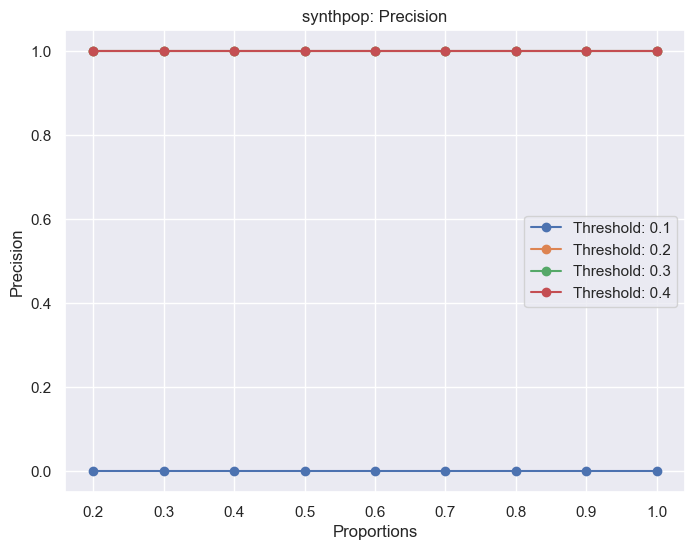

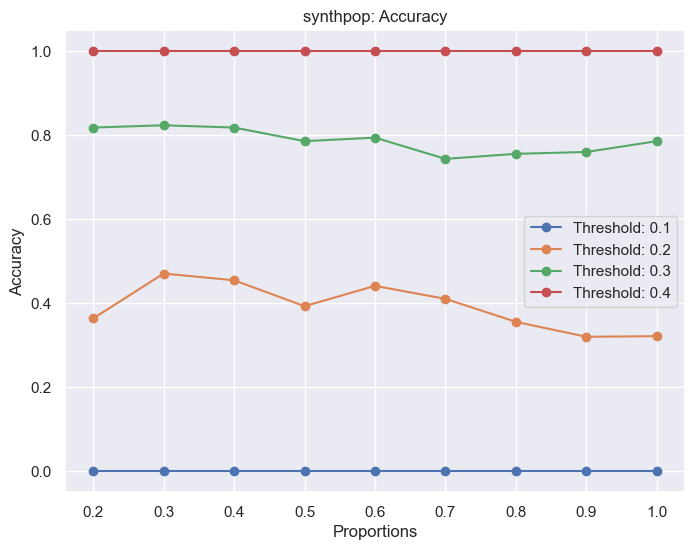

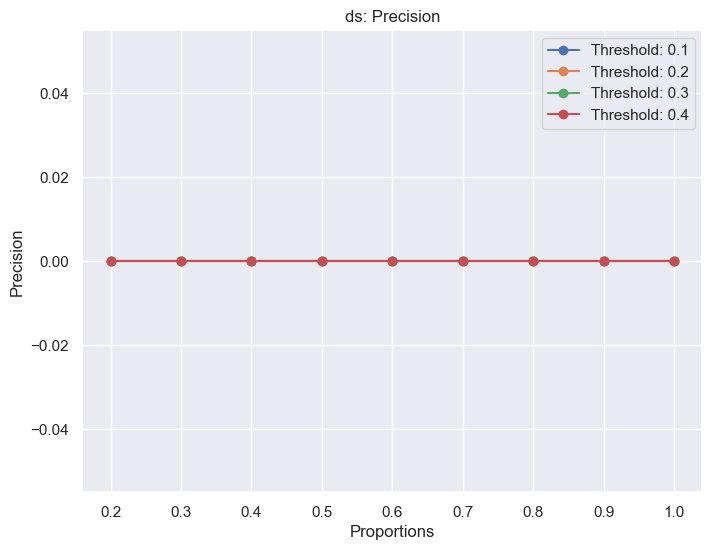

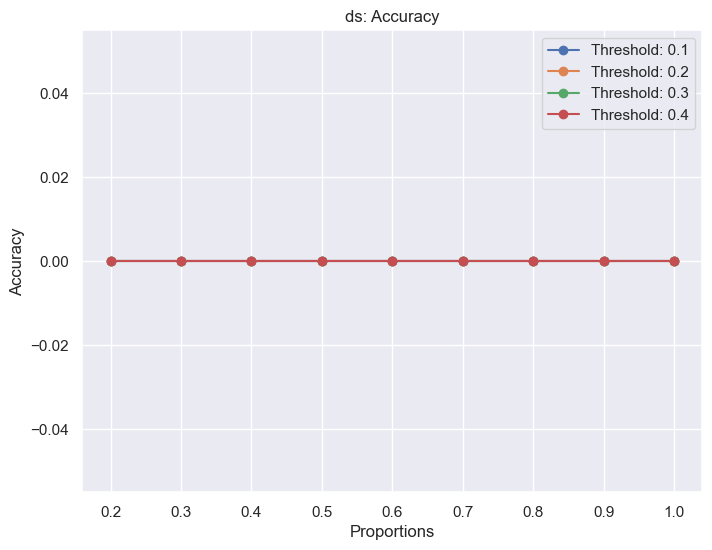

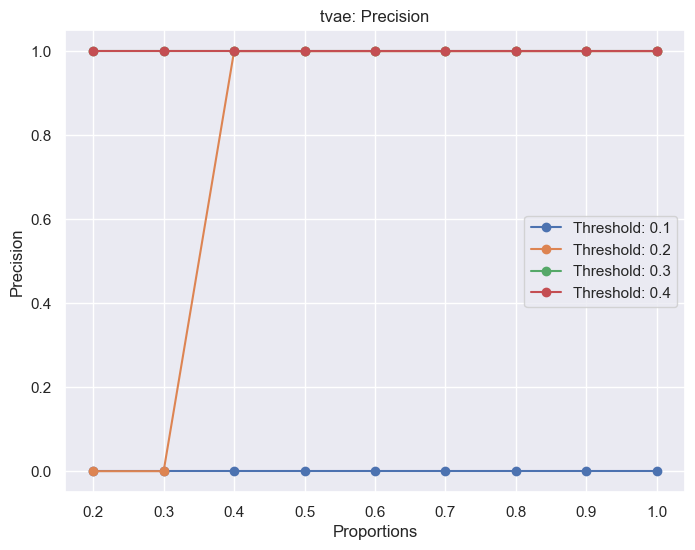

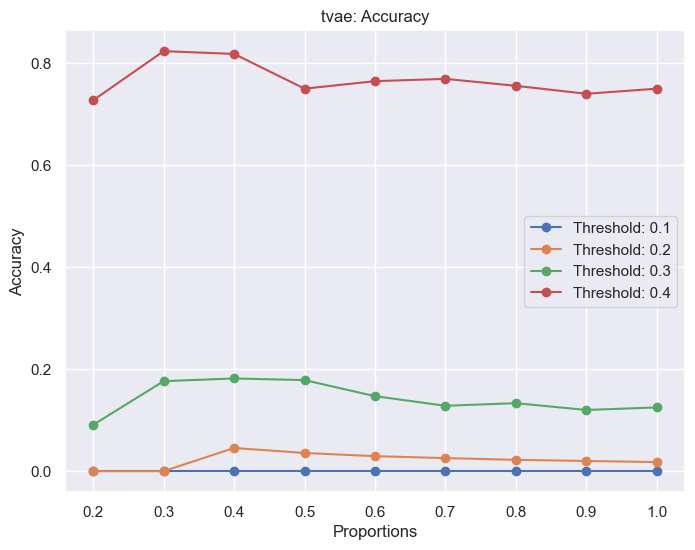

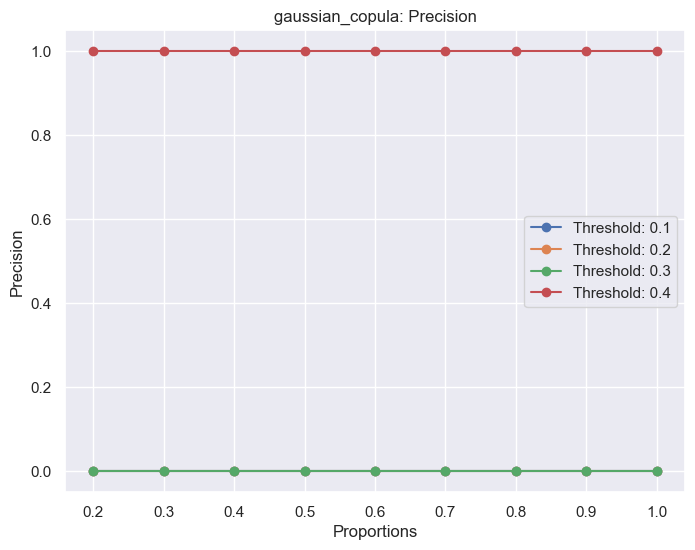

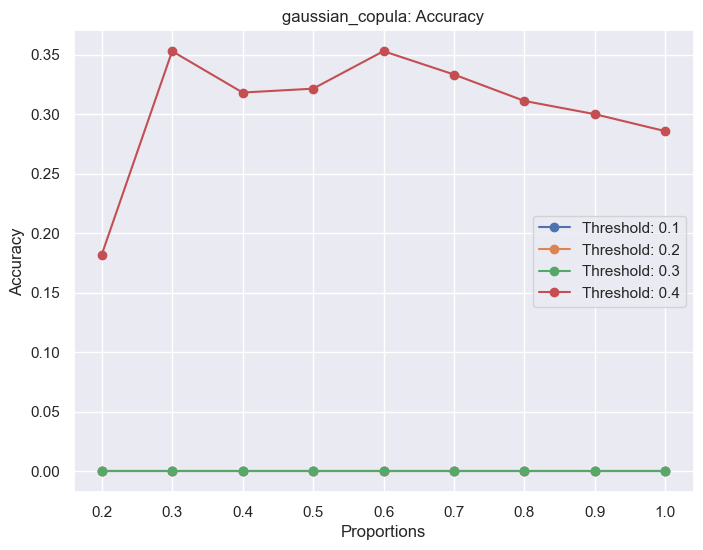

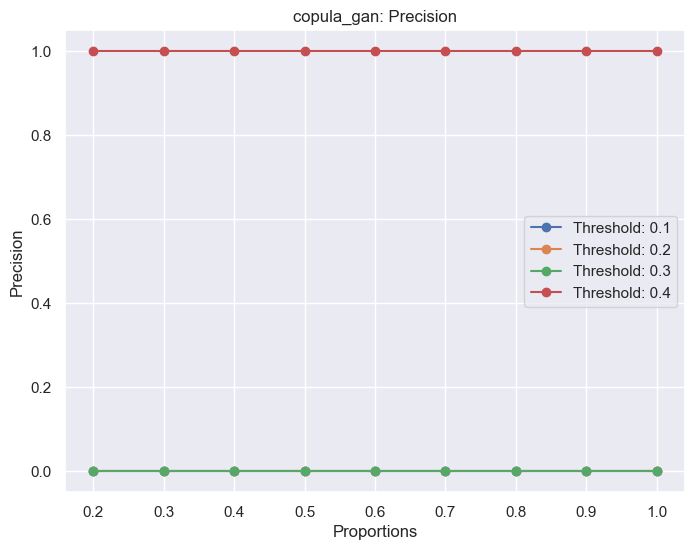

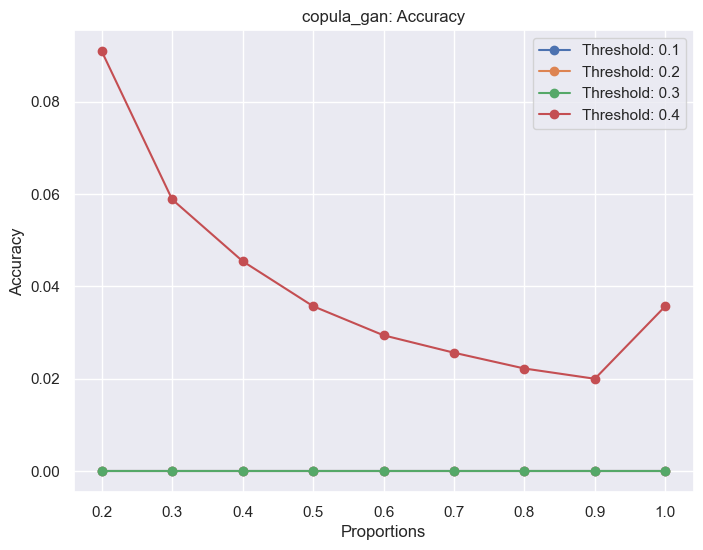

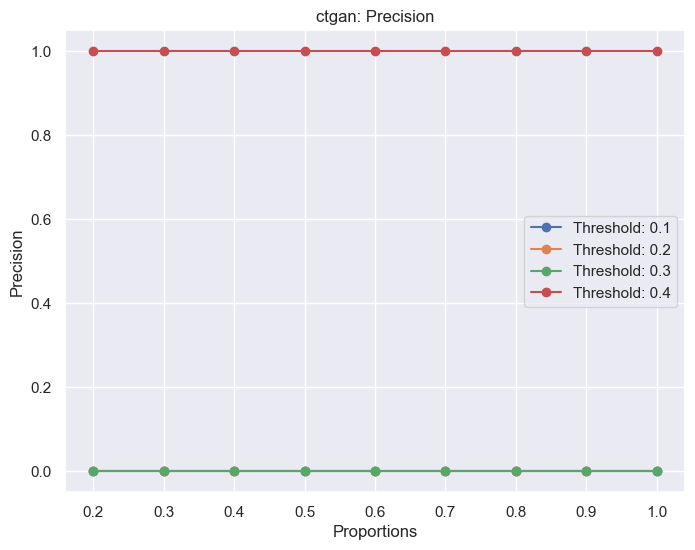

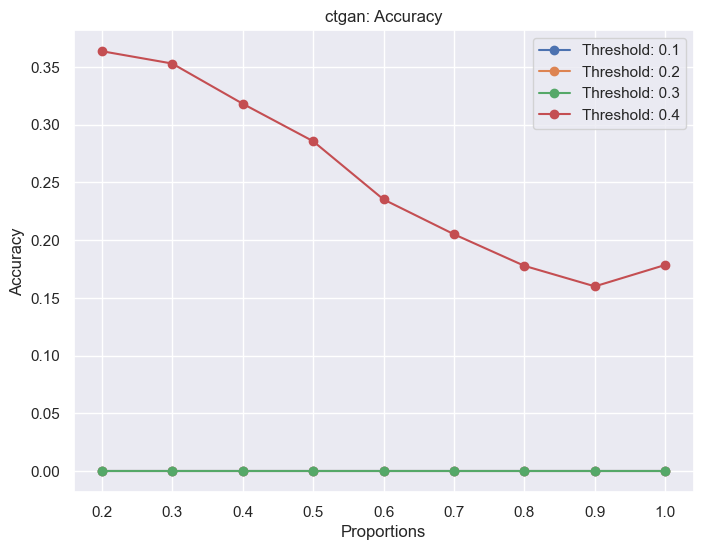

In [22]:
mia_results = {}
for i, model in enumerate(models):
    mia_results[model_names[i] + "prec"], mia_results[model_names[i] + "acc"]= mia(train_data, model, model_names[i],save_plts=True)
